# Проект 'Определение стоимости автомобилей'

## Подготовка данных

### Импорт библиотек

Установим дополнительные библиотеки.

In [1]:
!pip install catboost
!pip install fast_ml
!pip install lightgbm
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn -U

Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from fast_ml.model_development import train_valid_test_split
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

### Считываем данные и выводим общую информацию 

In [3]:
try:
    data = pd.read_csv('datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

Выведем общую информацию о данных:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Первые 5 строчек датасета:

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Покажем общую информацию о  каждом столбце:

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Предобработка данных

#### Пропуски

Проверим датасет на наличие пропусков (выведем количество и долю в процентах).

In [7]:
table_of_omissions = pd.DataFrame(data=pd.Series(data.isna().sum()), columns=['пропуски'])
table_of_omissions['доля_пропусков_%'] = round(data.isna().mean() * 100, 2)
table_of_omissions.style.background_gradient('coolwarm')

,пропуски,доля_пропусков_%
DateCrawled,0,0.000000
Price,0,0.000000
VehicleType,37490,10.580000
RegistrationYear,0,0.000000
Gearbox,19833,5.600000
Power,0,0.000000
Model,19705,5.560000
Kilometer,0,0.000000
RegistrationMonth,0,0.000000
FuelType,32895,9.280000


Большой датасет = много неидеальных данных. Попробуем разобраться с этой проблемой. \
Для того, чтобы оценить, можем ли мы удалить пропуски в том или ином столбце, мы показали долю пропусков в процентах. Исходя из этой информации сделаем следующие выводы:
1. В столбце **'Repaired'** ОЧЕНЬ много пропущенных значений. Это конечно может быть ошибкой, но, скорее всего, владельцы автомобилей таким образом скрывают факт ДТП или другие причины поломок автомобилей. Удалять **1/5 часть** датасета мы не можем, поэтому поместим такие анкеты в отдельную категорию ('unknown'), тем более отсутствие информации от ремонте может сказываться на цене авто.  
2. Второе место по пропускам занимает **'VehicleType'**, там их чуть больше **10%**. Избавляться от них не хотелось бы, к тому же у нас вроде бы есть возможность восстановить эту информацию. По названию бренда и модели можно было бы указать тип машины. Однако на деле не всё так просто: на примере автомобиля "Volkswagen Golf" можно увидеть, что одна и та же модель машины бывает представлена в разных кузовах. Так что пропускам будем приписывать категорию 'other'.
3. С **типом топлива** можно поступить точно также. 
4. А вот информацию в столбцах **'Gearbox'** и **'Model'** мы угадать не сможем. Модель автомобиля можно было бы попробовать вычислить по бренду и мощности, но к уверенному ответу это нас не приблизит. В случае с типом коробки передач ситуация такая же, но в добавок этот параметр меняется почти у каждой модели автомобиля. Пропусков в двух этих параметрах не так много (**~5%**), так что удалим их.

Выводы сделаны. Перейдём к действиям.

In [8]:
data['Repaired'].fillna('unknown', inplace=True) # создали отдельную категорию

Теперь покажем неоднозначность типов кузова:

In [9]:
data.query('Brand == "volkswagen" & Model == "golf"')['VehicleType'].unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

Для определения этого параметра видимо нужно отдельная модель :)
В нашем случае будет лучше заменить на аналог 'unknown' из столбца 'Repaired'.

In [10]:
data['VehicleType'].fillna('other', inplace=True)
data['FuelType'].fillna('other', inplace=True)
data.dropna(subset=['Gearbox', 'Model'], inplace=True) # удалили пропуски

In [11]:
data.reset_index(drop=True, inplace=True) # восстановили индексы
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Пропусков больше нет. Ура!

#### Дубликаты

Теперь проверим дубликаты:

In [12]:
data.duplicated().sum()

4

Всего 4 одинаковые строчки в датасете с сотнями тысяч автомобилей. На них можно даже не обращать внимания, но на всякий случай удалим:

In [13]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

#### Аномалии

Для выявления чересчур больших или маленьких значений в столбцах взглянем, какие элементы встречаются в каждом из них:

In [14]:
def unique_columns(df):
    for column in df.columns:
        print(f'Уникальные элементы столбца {column}')
        print(f'{df[column].unique()}\n')

In [15]:
unique_columns(data)

Уникальные элементы столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-14 12:52:21' '2016-03-17 16:54:04' ...
 '2016-03-19 19:53:49' '2016-03-21 09:50:58' '2016-03-19 18:57:12']

Уникальные элементы столбца Price
[  480  9800  1500 ... 12395 18429 10985]

Уникальные элементы столбца VehicleType
['other' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe']

Уникальные элементы столбца RegistrationYear
[1993 2004 2001 2008 1995 1980 2014 1998 2005 2011 2007 2009 2002 2018
 1997 1990 2017 1981 2003 2016 1991 1984 2006 1999 2012 2010 2000 1992
 2013 1994 1996 1989 2015 1985 1982 1983 1973 1969 1971 1987 1988 1986
 1965 1970 1945 1974 1955 1978 1976 1979 1972 1977 1961 1966 1975 1968
 1963 1954 1967 1960 1500 1964 1910 1962 2019 1937 1951 1953 1959 1958
 1956 2900 5911 1400 1950 4000 1200 1932 1952 3700 5000 1942 1935 3000
 6500 1957 1923 1930 1929 1943 1934 1938 9000 1936 1000 1919 6000 1928
 1931 4500 1602 1927 7100 1933 8200 1947 7500 1600]

Уникальные элементы столбца Gearbox
['m

Сразу бросаются в глаза следующие вещи:
- в датасете есть автомобили из прошлого и будущего (годы регистрации <1900 и >2023)
- мощность не всегда соответствует действительности
- в 'RegistrationMonth' есть загадочный нулевой месяц


Рассмотрим каждый момент подробнее. \
Начнём со столбцов "год регистрации" и "дата скачивания анкеты из базы". 
Преобразуемvтип последнего в 'datetime64[ns]'.

In [16]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

In [17]:
data['DateCrawled'].sort_values()

296518   2016-03-05 14:06:22
198481   2016-03-05 14:06:23
292298   2016-03-05 14:06:24
159128   2016-03-05 14:06:24
198501   2016-03-05 14:06:25
                 ...        
183756   2016-04-07 14:36:53
48396    2016-04-07 14:36:54
270909   2016-04-07 14:36:55
305679   2016-04-07 14:36:56
81638    2016-04-07 14:36:58
Name: DateCrawled, Length: 318958, dtype: datetime64[ns]

Отсортировав даты, мы видим, что все анкеты были скачаны из базы с марта по апрель 2016 года. Это означает, что, если у автомобиля год и месяц регистрации позже этого периода, то это явно некорректные данные. Проверим, есть ли такие анкеты.

In [18]:
data.query('RegistrationYear > 2016 | (RegistrationYear == 2016 & RegistrationMonth > 4)').shape[0]

14765

Вот они и попались! Строк с ложным годом регистрации много, но это точно недопустимая информация. Рассмотрим нижнюю границу допустимых дат и удалим выбросы. 

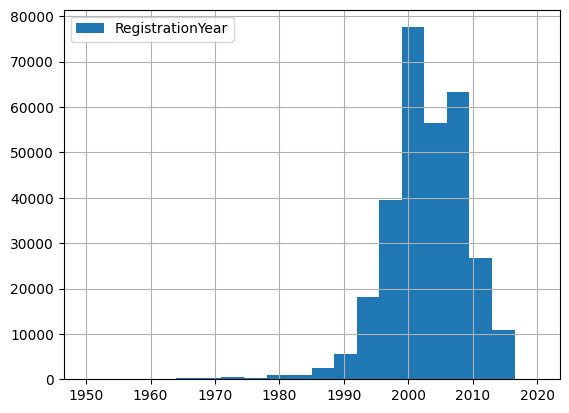

In [22]:
data['RegistrationYear'].hist(range=(1950, 2020), bins=20, legend=True);

Если рассмотреть различные диаграммы, то будет видно, что большая часть автомобилей относится к 1990-2020 годам. Но по содержанию уникальных элементов мы знаем о наличии выбросов. Обозначим допустимые временные границы для даты регистрации автомобиля, чтобы не возникло никакой путаницы.

In [23]:
data.query('RegistrationYear < 1900 | RegistrationYear > 2016 | (RegistrationYear == 2016 & RegistrationMonth > 4)').shape[0]

0

In [24]:
data.query('RegistrationYear > 1900 & (RegistrationYear < 2016 | (RegistrationYear == 2016 & RegistrationMonth <= 4))', 
           inplace=True)
data.reset_index(drop=True, inplace=True) # восстановили индексы

Перейдём к стобцу мощностей. \
Немного покопавшись в интернете, можно выяснить, что у самых маломощных мини-автомобилей вполне может быть двигатель всего в несколько л.с. (а имеено от 4-х). Для высоких значений стоит иметь ввиду, что на момент 2018 года самым мощным двигателем мреди авто обладал спорткар 'Hennessey Venom F5' (1600 л.с.). Значения в >100000 л.с. характерны уже для корабельных двигателей, что в нашем случае скорее ошибка, чем правда.


In [25]:
bad_power = data.query('Power < 4 | Power > 1600')
bad_power.shape[0]

21013

Такого точно никто не ожидал. У ~24 тыс. строчек некорректно указана мощность двигателя. 

In [26]:
bad_power['Power'].value_counts()

Power
0        20855
1           18
2            5
1800         5
1700         3
         ...  
1910         1
1703         1
11635        1
11509        1
3            1
Name: count, Length: 123, dtype: int64

Почти у всех них нулевая мощность. Это явно какая-то массовая ошибка. Попробуем восстановить эту информацию по медианной мощности у таких же моделей машин. \
Для этого заменим неправильные значения на пустые и заполним их методом 'fillna'.

In [27]:
data.loc[(data['Power'] > 1600) | (data['Power'] < 4), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))

Проверим результат:

In [28]:
print('Уникальные элементы:\n', data['Power'].unique())
data.dropna(subset=['Power'], inplace=True)
print('\nКоличество пустых элементов:', data['Power'].isna().sum())
data['Power'].dtype

Уникальные элементы:
 [ 101.   163.    75.    69.   102.   109.    50.   125.   105.   140.
  115.   131.   190.   136.   160.   231.   118.   193.    99.    60.
  113.   218.   122.   129.    70.   306.    95.    61.   177.   170.
   55.   143.   155.   232.   150.   156.    80.    82.    90.   185.
   87.   180.    86.    84.   224.   235.   200.   178.   265.    77.
  110.   144.   120.    54.   286.   116.   184.   126.   204.    88.
  194.    64.   305.   197.   179.   250.   245.   313.    45.   165.
   98.    41.   130.   114.   211.    56.   201.   213.    58.   107.
  174.   100.   220.    73.   192.    66.    74.    52.   147.   310.
   71.    97.    65.   239.    68.   203.   300.   103.    85.   258.
  320.    63.    81.   148.    44.    83.   145.   280.   260.   104.
  188.   333.   117.   141.   132.   234.   158.    39.    92.    51.
  135.    59.   230.    53.   209.    43.   146.    67.   106.   166.
  276.   344.    72.   237.   111.   299.   326.   279.   191.    23

dtype('float64')

Исправим тип c float на int.

In [29]:
data['Power'] = data['Power'].astype('int')

Столбец 'Price'.

In [30]:
data['Price'].value_counts()

Price
0        6506
500      4609
1500     4491
1200     3838
2500     3724
         ... 
8189        1
19295       1
3038        1
15232       1
14989       1
Name: count, Length: 3593, dtype: int64

Мы видим, что 7 тысяч значений целевого признака - нулевые. Это может негативно сказаться на дальнейших прогнозах моделей, но и восстановить цену по среднему для данной модели тоже будет неправильно. Такие анкеты придётся удалить.

In [31]:
data.query('Price != 0', inplace=True)

Теперь разберемся со столбцом 'RegistrationMonth'.

In [32]:
data['RegistrationMonth'].value_counts()

RegistrationMonth
3     30900
6     27194
4     25972
5     25312
7     23646
10    22847
12    21178
9     20987
11    20946
1     20392
0     19726
8     19618
2     18962
Name: count, dtype: int64

In [33]:
print('Доля странных месяцев регистрации в процентах: {:.2%}'
      .format(data[data['RegistrationMonth'] == 0].shape[0] / data.shape[0]))

Доля странных месяцев регистрации в процентах: 6.63%


Отнести их к отдельной категории не получится, поэтому у нас есть 2 варианта: 
- распределить их равномерно по всем остальным группам 
- удалить 

Первый способ может повлиять на итоговый результат, поэтому нам ничего не остаётся, кроме как убрать эти анкеты из рассмотрения. \
Аномалии рассмотрены. Выделим признаки, которые понадобятся для построения моделей.

#### Выделение информативных признаков

In [34]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Для предсказания цены, безусловно, важны **технические характеристики** автомобиля: мощность, тип коробки передач и т.д. \
Также может понадобится **информация о его прошлом**: дата регистрации, километраж и т.д. \
Исходя из этого удалим ненужные признаки.

In [35]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [36]:
data.reset_index(drop=True, inplace=True) # восстановили индексы

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297680 entries, 0 to 297679
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              297680 non-null  int64 
 1   VehicleType        297680 non-null  object
 2   RegistrationYear   297680 non-null  int64 
 3   Gearbox            297680 non-null  object
 4   Power              297680 non-null  int32 
 5   Model              297680 non-null  object
 6   Kilometer          297680 non-null  int64 
 7   RegistrationMonth  297680 non-null  int64 
 8   FuelType           297680 non-null  object
 9   Brand              297680 non-null  object
 10  Repaired           297680 non-null  object
dtypes: int32(1), int64(4), object(6)
memory usage: 23.8+ MB


### Гистограммы и корреляции

Выведем гистограммы для всех числовых столбцов.

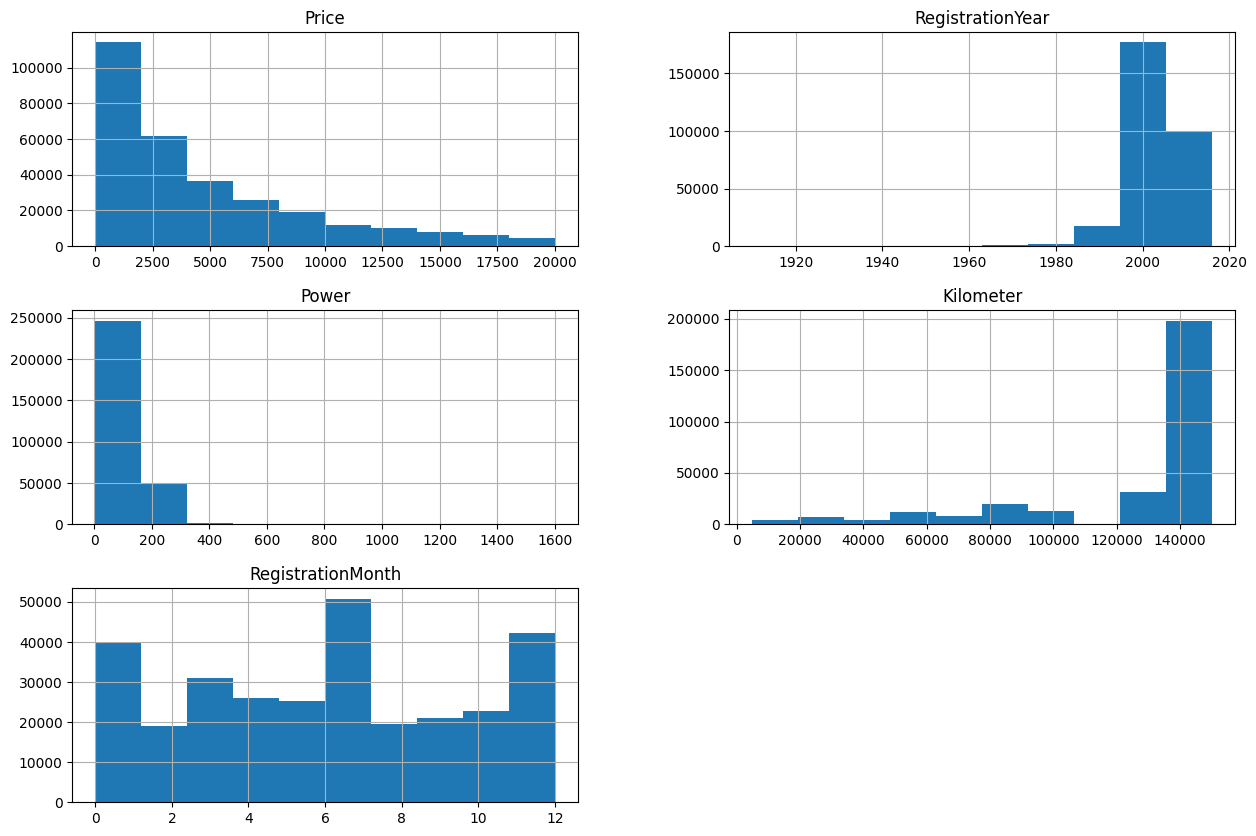

In [43]:
data.hist(figsize=(15, 10));

Проверим зависимости:

In [47]:
data[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']].corr().style.background_gradient(cmap='bwr')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.518944,0.459628,-0.384525,0.077315
RegistrationYear,0.518944,1.000000,0.133357,-0.304515,0.037446
Power,0.459628,0.133357,1.000000,0.093349,0.040763
Kilometer,-0.384525,-0.304515,0.093349,1.000000,-0.015366
RegistrationMonth,0.077315,0.037446,0.040763,-0.015366,1.000000


Как видно из таблицы, очень большое влияние на цену имеют: год регистрации, мощность двигателя и километраж.

### Подготовка к обучению

Теперь подготовим выборки для обучения моделей. \
Разделим данные на обучающую, валидационную и тестовую выборки (используем библиотеку fast_ml, чтобы удобно разбить данные).

In [48]:
features_train, target_train, features_valid, \
target_valid, features_test, target_test =  train_valid_test_split(data, target='Price',
                                                                   train_size=0.6, 
                                                                   valid_size=0.2, 
                                                                   test_size=0.2,
                                                                   random_state=12345
                                                                  )

Проверим корректность разделения:

In [49]:
print('Размер обучающей выборки:', len(features_train), 'или', len(features_train) / len(data) * 100, '%')
print('Размер валидационной выборки:', len(features_valid), 'или',len(features_valid) / len(data) * 100, '%')
print('Размер тестовой выборки:', len(features_test), 'или',len(features_test) / len(data) * 100, '%')

Размер обучающей выборки: 178608 или 60.0 %
Размер валидационной выборки: 59536 или 20.0 %
Размер тестовой выборки: 59536 или 20.0 %


Преобразуем категориальные признаки с помощью OneHotEncoder (так как OrdinalEncoder создаёт дополнительные зависимости в данных) и отмасштабируем их.

In [50]:
features_train.head(3)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
25736,sedan,1999,manual,170,3er,150000,4,petrol,bmw,yes
107928,other,2000,manual,116,other,150000,0,petrol,alfa_romeo,unknown
38997,small,1998,manual,75,polo,150000,12,petrol,volkswagen,yes


Выделим категориальные и количественные признаки:

In [51]:
cat_features = features_train.columns[features_train.dtypes == object].to_list()
print(cat_features)

num_features = features_train.columns[features_train.dtypes != object].to_list()
print(num_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


Отмасштабируем столбцы 'num_features' и сразу закодируем столбцы 'cat_features'. Для этого мы можем использовать make_column_transformer следующим образом:

In [52]:
preprocessor = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse_output=False), cat_features),
    remainder='passthrough'
)

preprocessor.set_output(transform='pandas').fit(features_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['RegistrationYear', 'Power', 'Kilometer',
                                  'RegistrationMonth']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                                  'Brand', 'Repaired'])])

In [53]:
transformed_features_train = preprocessor.transform(features_train)
transformed_features_valid = preprocessor.transform(features_valid)
transformed_features_test = preprocessor.transform(features_test)

print('Признаки с закодированными категориальными переменными:')
transformed_features_train.head(3)

Признаки с закодированными категориальными переменными:


,standardscaler__RegistrationYear,standardscaler__Power,standardscaler__Kilometer,standardscaler__RegistrationMonth,onehotencoder__VehicleType_bus,onehotencoder__VehicleType_convertible,onehotencoder__VehicleType_coupe,onehotencoder__VehicleType_other,onehotencoder__VehicleType_sedan,onehotencoder__VehicleType_small,...,onehotencoder__Brand_smart,onehotencoder__Brand_subaru,onehotencoder__Brand_suzuki,onehotencoder__Brand_toyota,onehotencoder__Brand_trabant,onehotencoder__Brand_volkswagen,onehotencoder__Brand_volvo,onehotencoder__Repaired_no,onehotencoder__Repaired_unknown,onehotencoder__Repaired_yes
25736,-0.576987,0.849039,0.585714,-0.539334,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107928,-0.418723,-0.083689,0.585714,-1.648379,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
38997,-0.735251,-0.791871,0.585714,1.678756,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Вывод

Мы изучили данные о технических характеристиках и ценах автомобилей. Провели подробную предобработку данных, чтобы исправить все пропущенные и аномальные значения датасета. Рассмотрели связь признаков друг с другом и удалили те, которые не понадобятся нам при дальнейшей работе. Также, мы подготовили данные к обучению моделей, а именно: выделили целевой признак, закодировали категориальные признаки и выполнили масштабирование.

Теперь приступим к обучению моделей.

## Обучение моделей
Для каждой будем измерять **качество предсказания**, **время обучения** и **время предсказания**.

### Линейная регрессия
Начнём наше исследование с проверки простой модели линейной регрессии. Вдруг она окажется лучше градиентного бустинга?

In [54]:
%%time
linear_model = LinearRegression()
linear_model.fit(transformed_features_train, target_train)

CPU times: total: 31.2 s
Wall time: 6.07 s


LinearRegression()

In [55]:
pred_linear = linear_model.predict(transformed_features_valid)
rmse_linear = mean_squared_error(target_valid, pred_linear, squared=False)
print(f'RMSE линейной регрессии на валидационной выборке: {round(rmse_linear, 2)}')

RMSE линейной регрессии на валидационной выборке: 2634.16


Значение ошибки получилось слишком большим. Рассмотрим другие варианты.

### DecisionTreeRegressor

In [57]:
%%time

tree_model = DecisionTreeRegressor(random_state=12345)

# подберем оптимальные параметры глубины дерева
parameters = {'max_depth': [x for x in range(1, 30, 2)]}

grid_tree = GridSearchCV(tree_model,
                         parameters, 
                         cv=5, 
                         scoring='neg_mean_squared_error')
grid_tree.fit(transformed_features_train, target_train)

CPU times: total: 3min 54s
Wall time: 3min 56s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                       23, 25, 27, 29]},
             scoring='neg_mean_squared_error')

Выведем гиперпараметры:

In [60]:
print('Гиперпараметры', grid_tree.best_params_)

Гиперпараметры {'max_depth': 15}


Чтобы измерить время обучения модели с нужными гиперпараметрами повторим эту процедуру:

In [68]:
%%time

best_tree_model = DecisionTreeRegressor(random_state=12345, max_depth=15)

best_tree_model.fit(transformed_features_train, target_train)

CPU times: total: 5.56 s
Wall time: 5.59 s


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [70]:
pred_tree = best_tree_model.predict(transformed_features_valid)
rmse_tree = mean_squared_error(target_valid, pred_tree, squared=False)
print(f'RMSE DecisionTreeRegressor на валидационной выборке: {round(rmse_tree, 2)}')

RMSE DecisionTreeRegressor на валидационной выборке: 1861.06


У дерева решений с глубиной 15 результат уже гораздо лучше. Цель в rmse <= 2500 мы достигли, но попробуем улучшить эту метрику.

### CatBoost

Обучим модель на исходных признаках, так как CatBoostRegressor работает с категориальными переменными напрямую.

In [62]:
%%time

catboost_model = CatBoostRegressor(random_state=12345) 

# подберем оптимальные
parameters = [{
    'iterations': [100, 500],
    'depth': [5, 10]
}]

grid_catboost = GridSearchCV(catboost_model, parameters)
grid_catboost.fit(features_train, target_train, cat_features=cat_features, verbose=250)

Learning rate set to 0.5
0:	learn: 3303.4883317	total: 268ms	remaining: 26.5s
99:	learn: 1638.7479156	total: 5.87s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3304.7548269	total: 84.6ms	remaining: 8.38s
99:	learn: 1635.8649201	total: 4.7s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3306.0016558	total: 60.6ms	remaining: 6s
99:	learn: 1638.7526220	total: 4.24s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3316.3914691	total: 55.2ms	remaining: 5.47s
99:	learn: 1636.9491158	total: 4.27s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3321.6115515	total: 76.5ms	remaining: 7.57s
99:	learn: 1630.9676976	total: 4.35s	remaining: 0us
Learning rate set to 0.157545
0:	learn: 4140.6708380	total: 91.1ms	remaining: 45.4s
250:	learn: 1620.9590482	total: 16.1s	remaining: 16s
499:	learn: 1560.9827313	total: 32.2s	remaining: 0us
Learning rate set to 0.157545
0:	learn: 4141.8753468	total: 85.4ms	remaining: 42.6s
250:	learn: 1623.4428929	total: 16.5s	remaining: 16.4s
499:	learn: 1561.3945

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000025D16EA10D0>,
             param_grid=[{'depth': [5, 10], 'iterations': [100, 500]}])

In [65]:
print('Гиперпараметры', grid_catboost.best_params_)

Гиперпараметры {'depth': 10, 'iterations': 500}


Таким образом мы выяснили, что наилучшей RMSE CatBoostRegressor обладает при **depth=10** и **iterations=500**. \
Измерим время её обучения:

In [67]:
%%time

best_catboost_model = CatBoostRegressor(random_state=12345, iterations=500, depth=10)

best_catboost_model.fit(features_train, target_train, cat_features=cat_features, verbose=250)

Learning rate set to 0.163199
0:	learn: 4058.3055317	total: 316ms	remaining: 2m 37s
250:	learn: 1388.9300795	total: 49.2s	remaining: 48.8s
499:	learn: 1282.1844966	total: 1m 44s	remaining: 0us
CPU times: total: 12min 37s
Wall time: 1min 46s


In [69]:
pred_catboost = best_catboost_model.predict(features_valid)
rmse_catboost = mean_squared_error(target_valid, pred_catboost, squared=False)
print(f'RMSE CatBoostRegressor на валидационной выборке: {round(rmse_catboost, 2)}')

RMSE CatBoostRegressor на валидационной выборке: 1532.74


Мы улучшили значение метрики качества предсказания почти на 400 единиц.

### Вывод

Мы измерили временные затраты для каждой из 3-х моделей, а также нашли для всех них (кроме LinearRegression) наилучшие значения гиперпараметров. \
Теперь проанализиурем результаты.

## Анализ моделей

### Сравнительная таблица

Снова обратим внимание на критерии, которые в первую очередь важны заказчику:
- время обучения модели
- время предсказания модели
- качество предсказания

Для сравнение получившихся значений поместим их в один датасет.

In [71]:
results = [
    ['32.7s', 2633.94], 
    ['5.59 s', 1861.06], 
    ['1min 46s', 1532.74]
]
models = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor']

In [72]:
pd.DataFrame(data=results, index=models, columns=["fit_time", "RMSE"])

,fit_time,RMSE
LinearRegression,32.7s,2633.94
DecisionTreeRegressor,5.59 s,1861.06
CatBoostRegressor,1min 46s,1532.74


Исходя из этой таблицы, в качестве лучшей модели мы выберем **CatBoostRegressor**. Обосновать это решение можно тем, что у этой модели самое высокое качество предсказания при относительно небольшом времени обучения. Безусловно, быстрее всех обучается  **DecisionTreeRegressor**, однако точность у неё несколько хуже.

Проверим выбранную модель на тестовой выборке:

In [73]:
test_pred_catboost = best_catboost_model.predict(features_test)
test_rmse_catboost = mean_squared_error(target_test, test_pred_catboost, squared=False)
print(f'RMSE CatBoostRegressor на тестовой выборке: {round(test_rmse_catboost, 2)}')

RMSE CatBoostRegressor на тестовой выборке: 1509.81


Также посмотрим на график важности признаков.

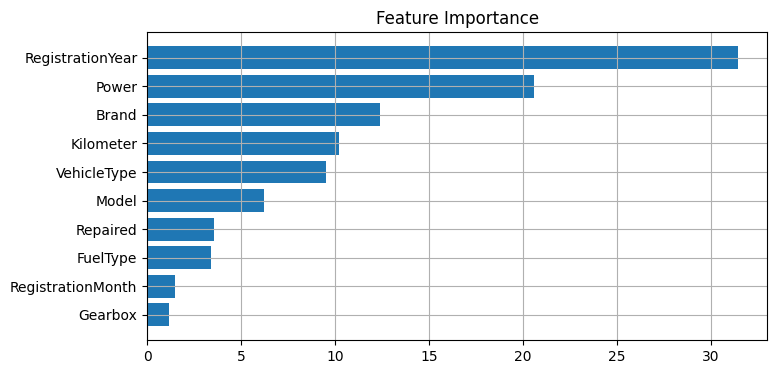

In [76]:
feature_importance = best_catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(True)

plt.show()

### Вывод
Мы составили сравнительную таблицу для регрессионных моделей, использованных в исследовании. Затем, основываясь на этих данных, выбрали лучшую модель (**CatBoostRegressor**) и вычислили RMSE это модели на тестовой выборке.

## Общий вывод

Мы использовали данные о технических характеристиках и ценах автомобилей, чтобы помочь компании по продаже автомобилей с пробегом «Не бит, не крашен» разработать приложение с фукнцией расчёта стоимости амтомобиля. \
Для достижения этой цели было сделано следующее:
1. Изучили датасет (рассмотрели значения в столбцах; разобрались с пропусками и аномалиями; удалили признаки, не влияющие на цену). Затем подготовили данные к обучению: закодировали категориальные столбцы техникой OrdinalEncoding и отмасштабировали их. Показали распределения признаков и их влияние друг на друга.
2. Обучили модели (разделили данные на обучающую, валидационную и тестовую выборки; замерили время обучения, предсказания и качество 3-х моделей: линейной регрессии, дерева решений и градиентного бустинга из библиотеки *Catboost*)
3. Сравнили полученные значения и выбрали лучшую модель (**CatBoostRegressor**), проверив её на тестовых данных. Показали важность признаков.

В итоге, критериям заказчика лучше всего соответствует предпоследняя рассмотренная модель с гиперпараметрами depth=10, iterations=500. Она имеет высокую точность (**1532.74**-на валидационной и **1509.81**-на тестовой выборках) и относительно небольшое время обучения (**1min 46s**). 